# ST000369
### Random Forest 
Questo dataset, basato su spettrometria di massa a gas-cromatografia (GC-MS), contiene 181 metaboliti identificati nel siero e nel plasma. In questa analisi confrontiamo il gruppo di pazienti con adenocarcinoma polmonare (Classe=1) con il gruppo di controllo sano (Classe=0).

### 1. Import Packages

In [28]:
# Librerie di base
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Librerie per la Data Imputation
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer

# Librerie per il modello di ML
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

# Librerie per la Hyperparameters Optimization
from sklearn.model_selection import GridSearchCV

# Librerie per la Features Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

# Librerie per la PCA
from sklearn.decomposition import PCA

# Librerie per la curva ROC
from sklearn.metrics import roc_curve, auc

print('All packages successfully loaded')

All packages successfully loaded


### 2. Load Data & Peak Sheet

In [29]:
df = pd.read_excel('../../../data/ST000369.xlsx')

# Rimuoviamo le colonne che non ci servono
df.drop(columns=["Idx", "SampleID", "Class"], inplace=True)

# Visualizziamo le prime 5 righe del dataset
df.head()

SampleType     HealthState SmokingStatus Sex   M1   M2   M3      M4   M5  \
0     Plasma  Adenocarcinoma        Former   F  194  168   77  105985  118   
1     Plasma  Adenocarcinoma        Former   F  215  143  154  100462  133   
2     Plasma  Adenocarcinoma       Current   F  104   67   45   75301   94   
3     Plasma  Adenocarcinoma       Current   M  360  642   82   42097   84   
4     Plasma  Adenocarcinoma       Current   M   96  137   95  112346  168   

      M6  ...  M172  M173  M174  M175   M176  M177  M178  M179  M180  M181  
0  15489  ...   195  1606   300   108   7203    43    59  1009   383    68  
1  13534  ...   184   364  1364   160  11910    82    99   136  1021   165  
2   7390  ...   189   157   884    73   6372    59    35   115   530    72  
3  50943  ...   320  1621   461   104  14011    69    86   845  1309   127  
4  41987  ...    84   769   266   158  18140    40    87  1213  1037   149  

[5 rows x 185 columns]

### 2.1 Data cleaning

Per quanto riguarda il data cleaning del dataset, sono necessarie due tipologie di operazioni sui dati: 
1. Alcuni valori della feature "*HealthState*" sono scritti incorrettamente, perciò dobbiamo effettuarne la correzione.
2. Tre features binarie sono espresse attraverso stringhe e non valori binari (0 e 1), perciò dobbiamo fare la sostituzione.

In [30]:
# Effettuiamo la correzione dei valori errati
df["HealthState"] = df["HealthState"].str.replace('Adenocarcnoma', 'Adenocarcinoma')

# Convertiamo i valori di natura categorica in valori numerici
df['Output'] = df['HealthState'].apply(lambda x: 1 if x in ['Adenosquamous', 'Adenocarcinoma'] else 0)
df['SmokingStatus'] = df['SmokingStatus'].apply(lambda x: 1 if x in ['Current'] else 0)
df['Sex'] = df['Sex'].apply(lambda x: 1 if x in ['F'] else 0)

Per valutazioni che faremo più avanti, creiamo un subset del dataframe contenente solo feature relative a metaboliti.

### 3. Extract X & Y

In [31]:
X = df.drop(columns=['SampleType', 'HealthState', 'Output'])
X_features_names = X.columns
y = df.Output

### 3.1 Data Imputation

Confrontiamo due delle tecniche di imputazione più note: Iterative Imputation e KNN Imputation.

In [32]:
# Confrontiamo KNNImputer e IterativeImputer

# IterativeImputer
imputer_it = IterativeImputer(max_iter=10)
imputer_it.fit(X)
X[:] = imputer_it.transform(X)
X_it = X.copy()

# KNNImputer
imputer_knn = KNNImputer()
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

/var/folders/dv/cqkd8q211lb6w_8jd__s86d40000gn/T/ipykernel_2003/4163179121.py:6: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X[:] = imputer_it.transform(X)


### 3.2 Train-test Split

In [33]:
X_train_it, X_test_it, y_train_it, y_test_it = train_test_split(X_it, y, test_size=0.2, random_state=42)
X_train_knn, X_test_knn, y_train_knn, y_test_knn = train_test_split(X_knn, y, test_size=0.2, random_state=42)

### 4. Build Model

In [34]:
# Definiamo i modelli
model_it = RandomForestClassifier(random_state=42)
model_knn = RandomForestClassifier(random_state=42)

# Addestriamo i modelli   
model_it.fit(X_train_it, y_train_it)
model_knn.fit(X_train_knn, y_train_knn)

# Eseguiamo le previsioni sui dati di test
predictions_it = model_it.predict(X_test_it)
predictions_knn = model_knn.predict(X_test_knn)

### 5. Initial Model Evaluation

In [35]:
# Valutiamo le prestazioni del modello con IterativeImputer
accuracy_it = metrics.accuracy_score(y_test_it, predictions_it)
precision_it = metrics.precision_score(y_test_it, predictions_it)
recall_it = metrics.recall_score(y_test_it, predictions_it)
f1_it = metrics.f1_score(y_test_it, predictions_it)
roc_auc_it = metrics.roc_auc_score(y_test_it, predictions_it)

# Valutiamo le prestazioni del modello con KNNImputer
accuracy_knn = metrics.accuracy_score(y_test_knn, predictions_knn)
precision_knn = metrics.precision_score(y_test_knn, predictions_knn)
recall_knn = metrics.recall_score(y_test_knn, predictions_knn)
f1_knn = metrics.f1_score(y_test_knn, predictions_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, predictions_knn)

print(f'Accuratezza con Iterative Imputer: {accuracy_it}')
print(f'Precision con Iterative Imputer: {precision_it}')
print(f'Recall con Iterative Imputer: {recall_it}')
print(f'F1-score con Iterative Imputer: {f1_it}')
print(f'ROC AUC con Iterative Imputer: {roc_auc_it}')
print("------------------------------------------")
print(f'Accuratezza con KNNImputer: {accuracy_knn}')
print(f'Precision con KNNImputer: {precision_knn}')
print(f'Recall con KNNImputer: {recall_knn}')
print(f'F1-score con KNNImputer: {f1_knn}')
print(f'ROC AUC con KNNImputer: {roc_auc_knn}')


Accuratezza con Iterative Imputer: 0.6486486486486487
Precision con Iterative Imputer: 0.7368421052631579
Recall con Iterative Imputer: 0.6363636363636364
F1-score con Iterative Imputer: 0.6829268292682926
ROC AUC con Iterative Imputer: 0.6515151515151516
------------------------------------------
Accuratezza con KNNImputer: 0.6486486486486487
Precision con KNNImputer: 0.7368421052631579
Recall con KNNImputer: 0.6363636363636364
F1-score con KNNImputer: 0.6829268292682926
ROC AUC con KNNImputer: 0.6515151515151516


Proviamo con la K-Fold Cross Validation.

Il numero ottimale di K è 6.

In [36]:
# Creiamo l'oggetto KFold per la Cross-Validation con il numero di fold ottimale
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

### 6. Hyperparameters Optimization

L'**ottimizzazione degli iperparametri** è un passo fondamentale nello sviluppo di modelli predittivi robusti. Infatti, aderire ai parametri predefiniti impedisce ai modelli di raggiungere il massimo delle prestazioni. A tale scopo, utilizziamo la tecnica **Grid Search**.

### 6.1 Random Forest Optimization

In [37]:
# Creiamo un nuovo modello Random Forest
model_2 = RandomForestClassifier(random_state=42)

# Definiamo la griglia con i parametri da testare
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 10, 15, 20, 25],
    'min_samples_leaf': [1, 2, 3, 4],
    'min_samples_split': [2, 3, 4],
    'class_weight': ['balanced']
}

# Creiamo l'oggetto GridSearchCV
grid_search = GridSearchCV(model_2, param_grid, scoring='accuracy', cv=kfolds, n_jobs=-1)

# Eseguiamo la ricerca e cross-validation sui dati di addestramento
grid_search.fit(X_knn, y)

# Ottieniamo i migliori parametri
best_params = grid_search.best_params_
print(f"Migliori parametri: {best_params}")

Migliori parametri: {'class_weight': 'balanced', 'max_depth': 10, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 400}


In [38]:
# Utilizziamo gli iperparametri ottimizzati per creare un nuovo modello
best_model = RandomForestClassifier(**best_params)

In [39]:
# Valutiamo le prestazioni del modello con gli iperparametri ottimizzati
best_model.fit(X_train_knn, y_train_knn)
y_pred_knn = best_model.predict(X_test_knn)

# Calcoliamo le metriche
accuracy_knn = metrics.accuracy_score(y_test_knn, y_pred_knn)
precision_knn = metrics.precision_score(y_test_knn, y_pred_knn)
recall_knn = metrics.recall_score(y_test_knn, y_pred_knn)
f1_knn = metrics.f1_score(y_test_knn, y_pred_knn)
roc_auc_knn = metrics.roc_auc_score(y_test_knn, y_pred_knn)

# Visualizziamo le metriche
print(f'Accuratezza: {accuracy_knn}')
print(f'Precision: {precision_knn}')
print(f'Recall: {recall_knn}')
print(f'F1-score: {f1_knn}')
print(f'ROC AUC: {roc_auc_knn}')

Accuratezza: 0.7837837837837838
Precision: 0.85
Recall: 0.7727272727272727
F1-score: 0.8095238095238095
ROC AUC: 0.7863636363636364


In [40]:
# K-Fold Cross Validation
scores = cross_val_score(best_model, X_knn, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')
print(f'Deviazione standard: {scores.std()}')

Accuratezza media: 0.7678362573099415
Deviazione standard: 0.06508327932608299


### 6.2 KNNImputator Optimization

In [41]:
# Definiamo il range di valori di n_neighbors da testare
n_neighbors_values = np.arange(1, 11)

# Creiamo un oggetto KNNImputer
max_nb = 0 
k_nb = 0

for n_neighbors in n_neighbors_values:

    imputer = KNNImputer(n_neighbors=n_neighbors)
    X_imputed = imputer.fit_transform(X)
    scores = cross_val_score(best_model, X_imputed, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_nb: 
        max_nb = mean
        k_nb = n_neighbors 

    print(f"K={n_neighbors}, Accuratezza Media: {mean}")

print(f"Numero di neighbors ottimale: {k_nb}")
print(f"Accuratezza media ottimale: {max_nb}")

K=1, Accuratezza Media: 0.768421052631579
K=2, Accuratezza Media: 0.7625730994152046
K=3, Accuratezza Media: 0.7736842105263158
K=4, Accuratezza Media: 0.7850877192982455
K=5, Accuratezza Media: 0.7789473684210526
K=6, Accuratezza Media: 0.7786549707602339
K=7, Accuratezza Media: 0.7847953216374269
K=8, Accuratezza Media: 0.7684210526315789
K=9, Accuratezza Media: 0.77953216374269
K=10, Accuratezza Media: 0.7570175438596491
Numero di neighbors ottimale: 4
Accuratezza media ottimale: 0.7850877192982455


In [42]:
X = df.drop(columns=['SampleType', 'HealthState', 'Output'])
imputer_knn = KNNImputer(n_neighbors=k_nb)
imputer_knn.fit(X)
X[:] = imputer_knn.fit_transform(X)
X_knn = X.copy()

/var/folders/dv/cqkd8q211lb6w_8jd__s86d40000gn/T/ipykernel_2003/1569292684.py:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  X[:] = imputer_knn.fit_transform(X)


### 7. Feature Selection

In [17]:
max_fs = 0 
k_fs = 0
best_features = []

for k in range(2, len(X_knn.columns)):
    top_features = SelectKBest(score_func=chi2, k=k).fit(X_knn, y).get_support(indices=True)
    X_top = X_knn.iloc[:, top_features]
    
    scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
    mean = np.mean(scores)
    
    if mean > max_fs: 
        max_fs = mean
        k_fs = k
        best_features = X_knn.columns[top_features].tolist()

    print(f"K={k}, Accuratezza Media: {mean}")

print(f"K ottimale: {k_fs}")
print(f"Accuratezza media ottimale: {max_fs}")
print(f"Features ottimali: {best_features}")

K=2, Accuratezza Media: 0.6239766081871345
K=3, Accuratezza Media: 0.6859649122807017
K=4, Accuratezza Media: 0.6807017543859648
K=5, Accuratezza Media: 0.7134502923976609
K=6, Accuratezza Media: 0.7298245614035087
K=7, Accuratezza Media: 0.7628654970760234
K=8, Accuratezza Media: 0.7570175438596491
K=9, Accuratezza Media: 0.7625730994152047
K=10, Accuratezza Media: 0.7576023391812865
K=11, Accuratezza Media: 0.735672514619883
K=12, Accuratezza Media: 0.7292397660818714
K=13, Accuratezza Media: 0.7464912280701754
K=14, Accuratezza Media: 0.7403508771929824
K=15, Accuratezza Media: 0.7076023391812866
K=16, Accuratezza Media: 0.7350877192982457
K=17, Accuratezza Media: 0.7295321637426901
K=18, Accuratezza Media: 0.7514619883040936
K=19, Accuratezza Media: 0.7400584795321639
K=20, Accuratezza Media: 0.7461988304093568
K=21, Accuratezza Media: 0.7350877192982456
K=22, Accuratezza Media: 0.7403508771929824
K=23, Accuratezza Media: 0.72953216374269
K=24, Accuratezza Media: 0.7511695906432749

In [18]:
X_top = X_knn[best_features]
scores = cross_val_score(best_model, X_top, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.8178362573099415


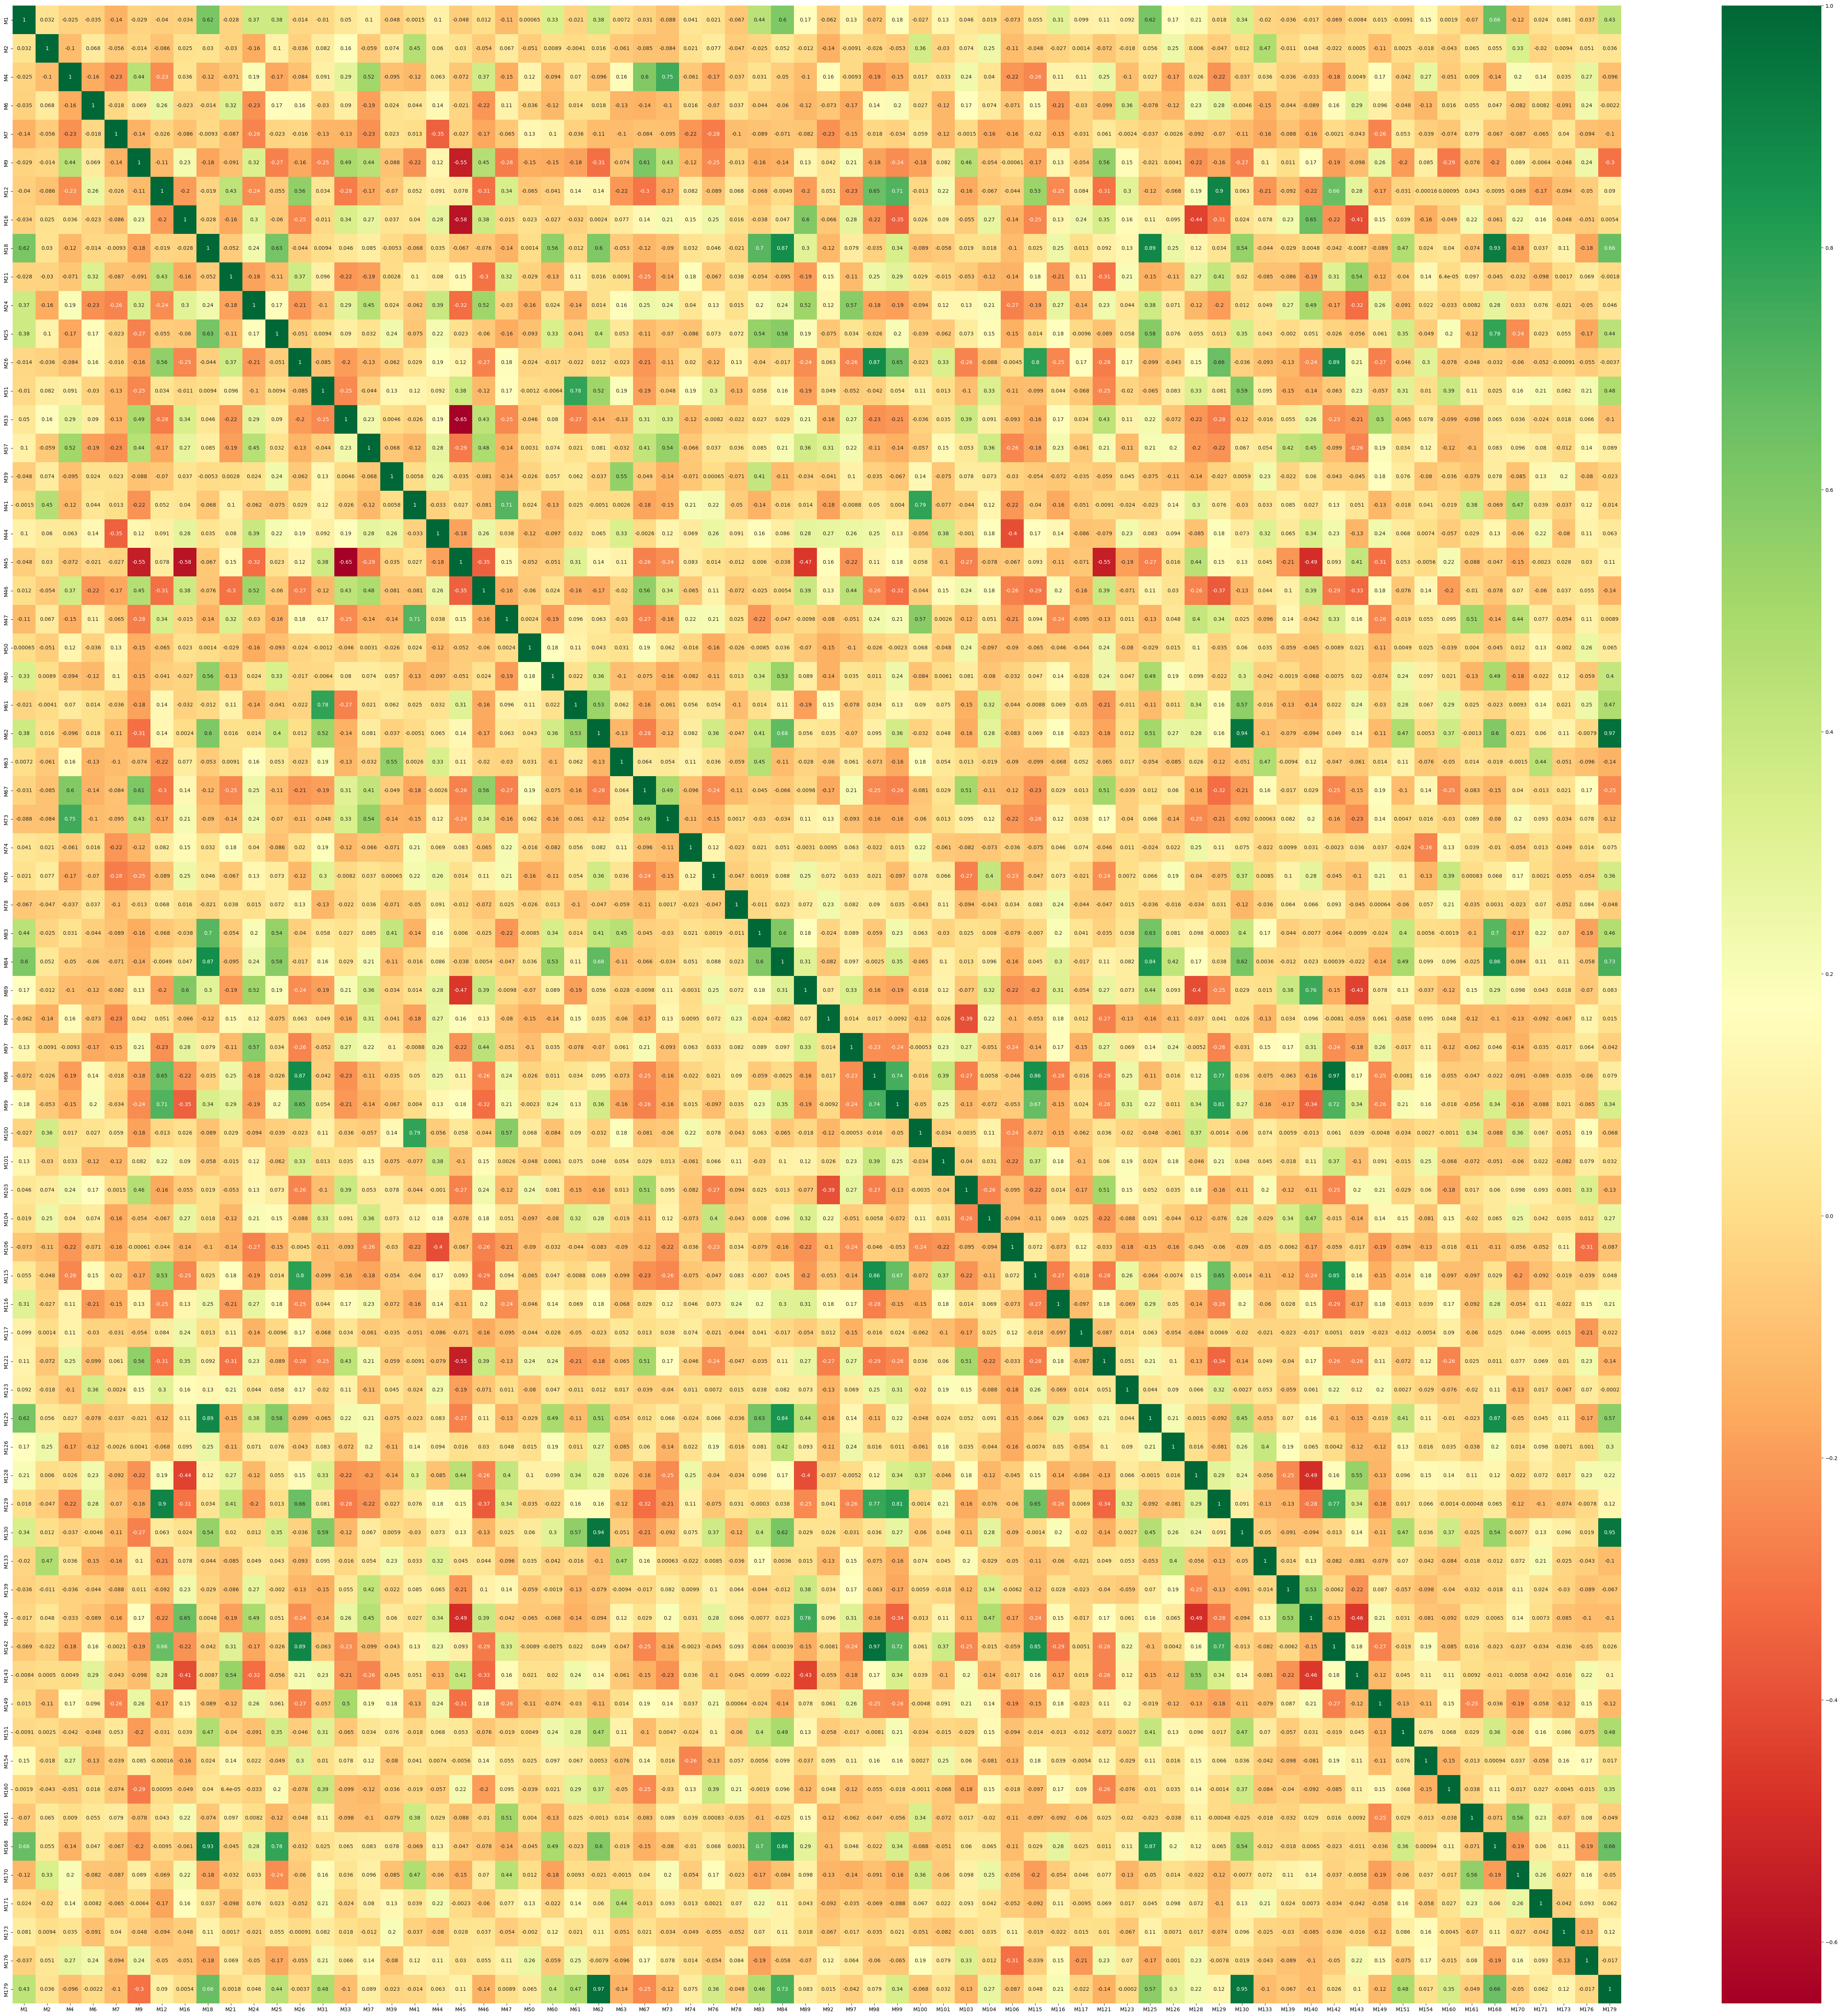

In [19]:
# Otteniamo le correlazioni tra le features
corrmat = X_top.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(k_fs, k_fs))

# Generiamo il grafico delle correlazioni
g=sns.heatmap(X_top[top_corr_features].corr(),annot=True,cmap="RdYlGn")

### 8. PCA

In [20]:
pca = PCA()
pca.fit(X_knn)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.8) + 1
print("Numero di componenti principali:", d)

pca = PCA(n_components=d)
X_reduced = pca.fit_transform(X_knn)

Numero di componenti principali: 4


In [21]:
scores = cross_val_score(best_model, X_reduced, y, cv=kfolds, scoring='accuracy')
print(f'Accuratezza media: {scores.mean()}')

Accuratezza media: 0.6312865497076025


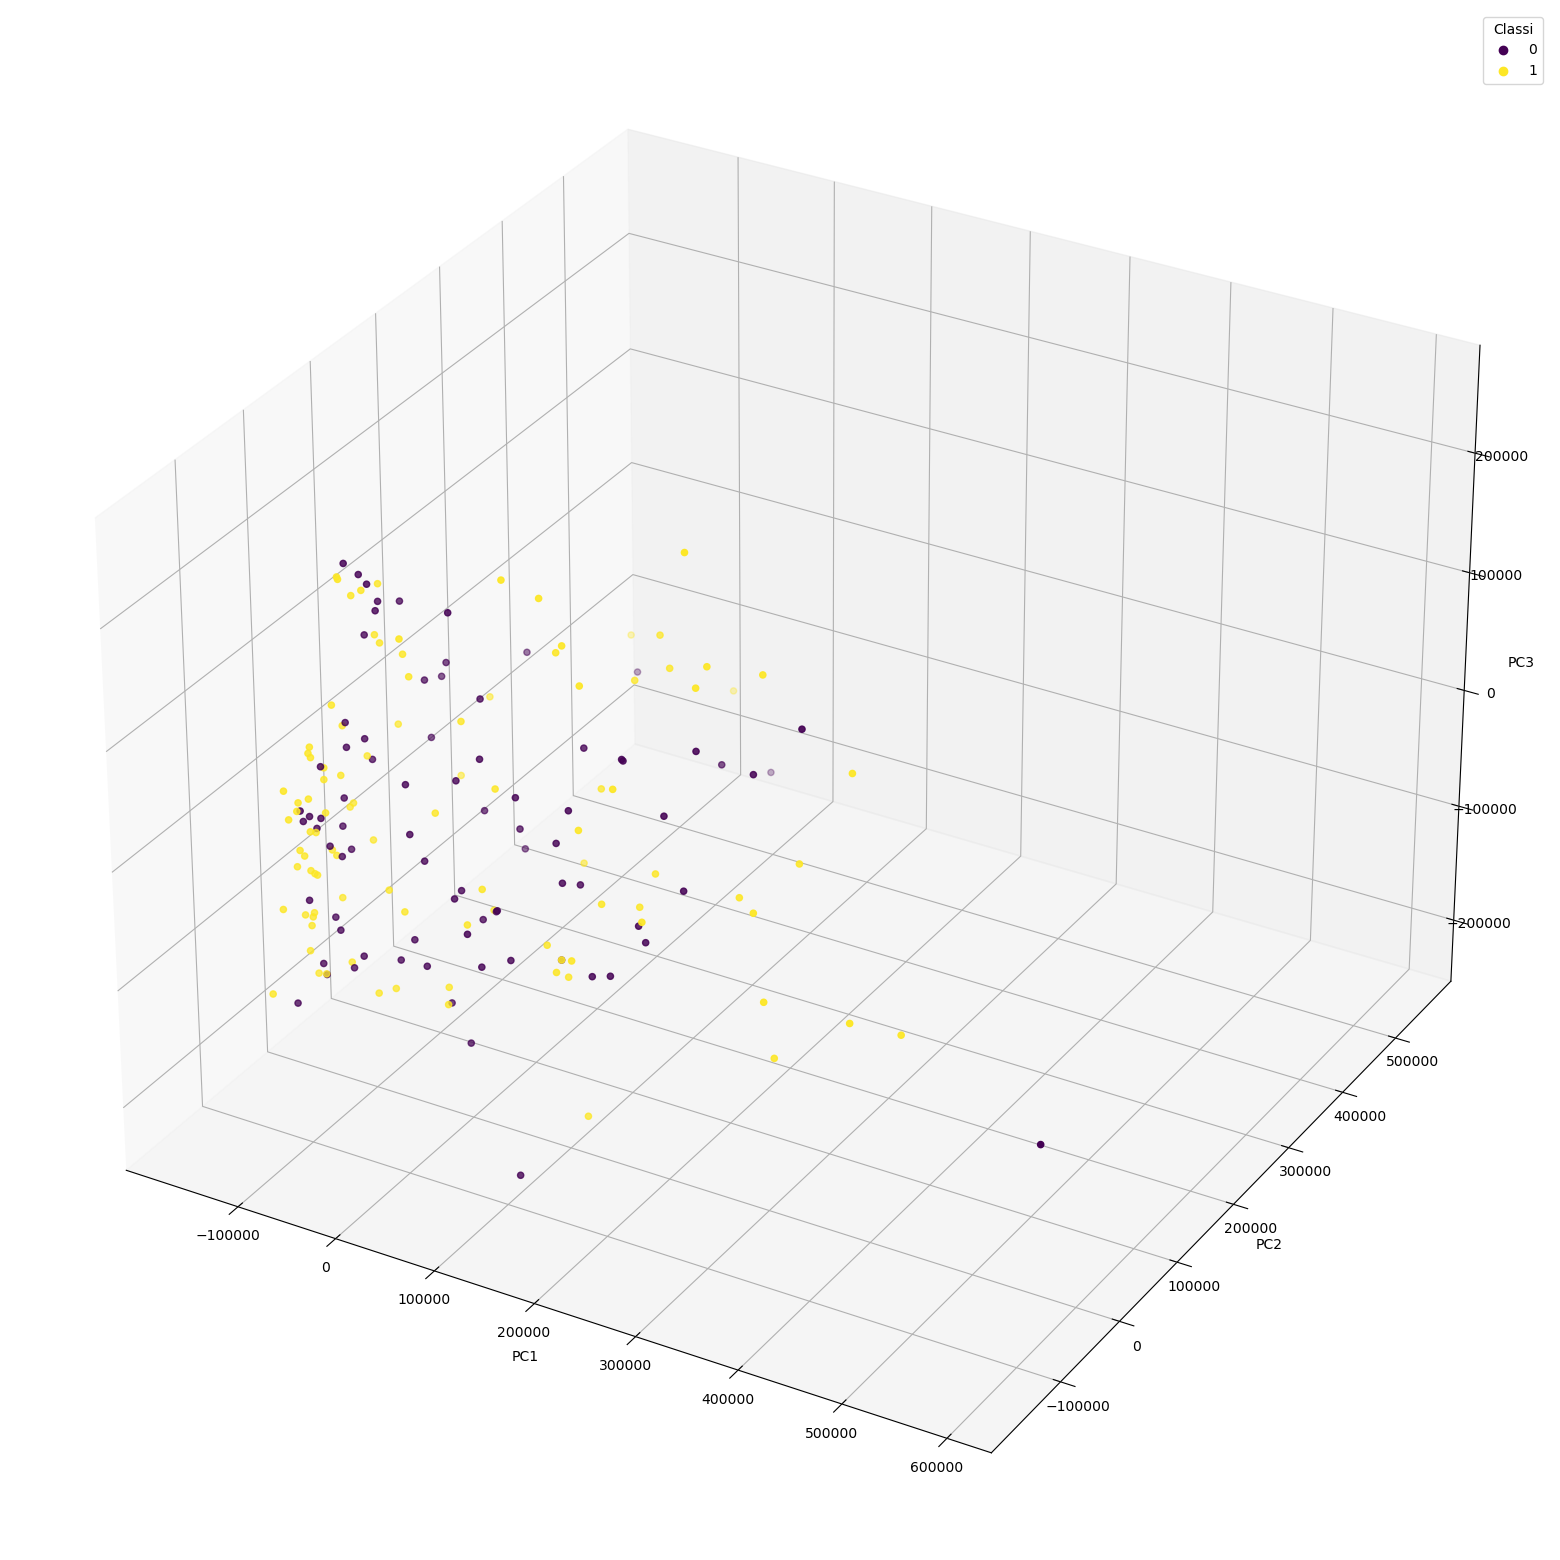

In [22]:
# Creazione di un grafico 3D
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

# Plotting dei punti nel grafico 3D
scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, cmap='viridis')

# Aggiungi etichette agli assi
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')

# Aggiungiamo una legenda per i colori
legend = ax.legend(*scatter.legend_elements(), title='Classi')

# Mostriamo il grafico
plt.show()

### 9. Results

In [23]:
# Numero ottimale di fold
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

# Modello con gli iperparametri ottimizzati
model = RandomForestClassifier(**best_params)

# K-Fold Cross Validation del modello con le features ottimali
y_pred = cross_val_predict(model, X_top, y, cv=kfolds, method='predict_proba')

# Scegliamo una soglia per trasformare le probabilità in etichette binarie
threshold = 0.5
y_pred = (y_pred[:, 1] > threshold).astype(int)

# Calcoliamo le metriche
accuracy = metrics.accuracy_score(y, y_pred)
precision = metrics.precision_score(y, y_pred)
recall = metrics.recall_score(y, y_pred)
f1 = metrics.f1_score(y, y_pred)
roc_auc = metrics.roc_auc_score(y, y_pred)

In [24]:
# Stampiamo i risultati
print("------------------------")
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-score: {f1:.4f}')
print(f'ROC AUC: {roc_auc:.4f}')

print("------------------------")
print(f'Matrice di confusione:\n {metrics.confusion_matrix(y, y_pred)}')
print("------------------------")
print(f'Migliori iperparametri:')
for h in best_params:
    print(f'- {h}: {best_params[h]}')
print("------------------------")
print(f'Features selezionate: {len(best_features)}')
print("------------------------")

------------------------
Accuracy: 0.8122
Precision: 0.7845
Recall: 0.9100
F1-score: 0.8426
ROC AUC: 0.8007
------------------------
Matrice di confusione:
 [[56 25]
 [ 9 91]]
------------------------
Migliori iperparametri:
- class_weight: balanced
- max_depth: 10
- min_samples_leaf: 3
- min_samples_split: 2
- n_estimators: 400
------------------------
Features selezionate: 70
------------------------


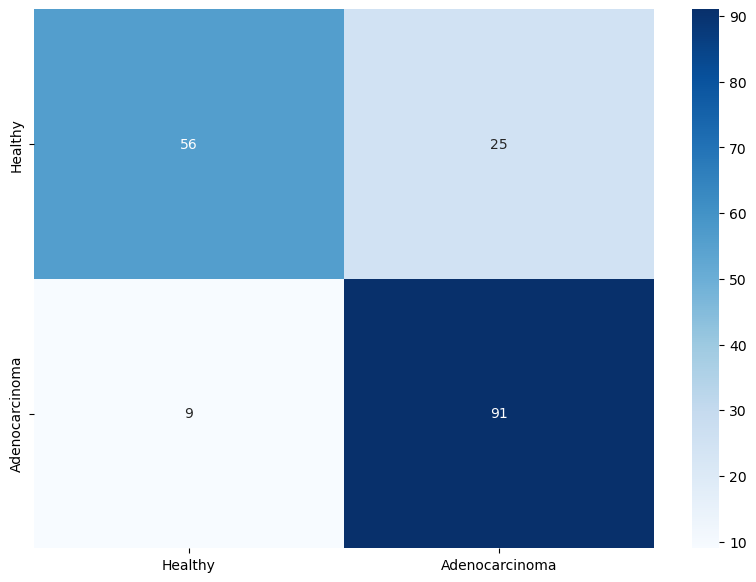

In [25]:
conf_mat = metrics.confusion_matrix(y, y_pred)
classes = ['Healthy', 'Adenocarcinoma']

df_cfm = pd.DataFrame(conf_mat, index=classes, columns=classes)
plt.figure(figsize=(10, 7))
cfm_plot = sns.heatmap(df_cfm, annot=True, cmap='Blues')
plt.show()

### 10. ROC Curve

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X_top, y, test_size=0.2, random_state=42)
model.fit(X_train, y_train)
y_train_pred_prob = model.predict(X_train)
y_test_pred_prob = model.predict(X_test)

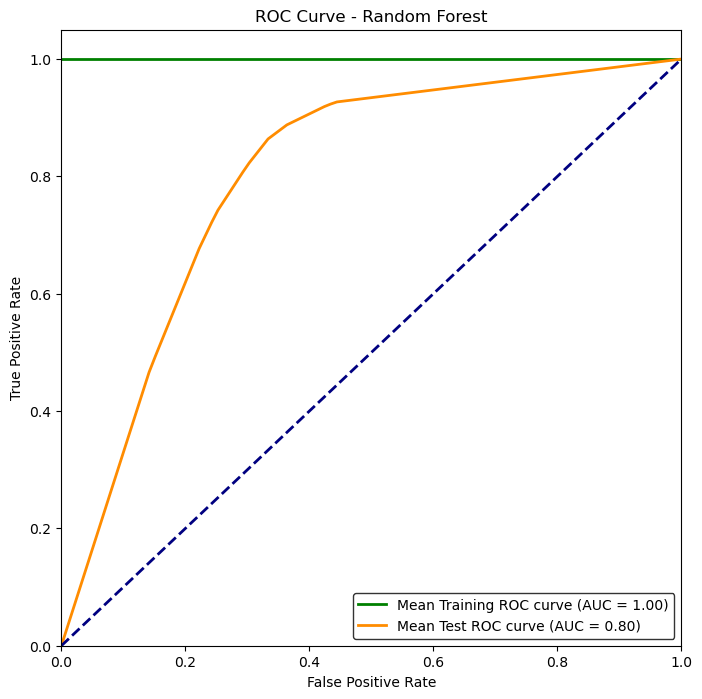

In [27]:
# Inizializziamo le liste per memorizzare i risultati dei singoli fold
all_fpr_train = []
all_tpr_train = []
all_fpr_test = []
all_tpr_test = []

# Eseguiamo la k-fold cross-validation
for train_idx, test_idx in kfolds.split(X_top, y):
    X_train, X_test = X_top.iloc[train_idx], X_top.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Addestriamo il modello sul training set
    model.fit(X_train, y_train)

    # Calcoliamo le probabilità di classe per i dati di training e test
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calcoliamo la curva ROC per i dati di training
    fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred)
    all_fpr_train.append(fpr_train)
    all_tpr_train.append(tpr_train)

    # Calcoliamo la curva ROC per i dati di test
    fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred)
    all_fpr_test.append(fpr_test)
    all_tpr_test.append(tpr_test)

# Calcoliamo le curve ROC medie per i dati di training
mean_fpr_train = np.linspace(0, 1, 100)
mean_tpr_train = np.mean([np.interp(mean_fpr_train, fpr, tpr) for fpr, tpr in zip(all_fpr_train, all_tpr_train)], axis=0)
roc_auc_train = auc(mean_fpr_train, mean_tpr_train)

# Calcoliamo le curve ROC medie per i dati di test
mean_fpr_test = np.linspace(0, 1, 100)
mean_tpr_test = np.mean([np.interp(mean_fpr_test, fpr, tpr) for fpr, tpr in zip(all_fpr_test, all_tpr_test)], axis=0)
roc_auc_test = auc(mean_fpr_test, mean_tpr_test)

# Grafichiamo le curve ROC medie
plt.figure(figsize=(8, 8))
plt.plot(mean_fpr_train, mean_tpr_train, color='green', lw=2, label=f'Mean Training ROC curve (AUC = {roc_auc_train:.2f})')
plt.plot(mean_fpr_test, mean_tpr_test, color='darkorange', lw=2, label=f'Mean Test ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc="lower right", facecolor='white', edgecolor='black')
plt.show()